In [17]:
%load_ext watermark
import warnings
warnings.filterwarnings("ignore") 
from IPython.core.display import display, HTML

import time

import pandas as pd
import pandas_datareader.data as web
import numpy as np
import scipy.stats as scs
from scipy.stats import multivariate_normal as mvn
import sklearn.mixture as mix

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

%watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
2017-11-10T22:38:38+05:30

CPython 3.5.2+
IPython 6.1.0

compiler   : GCC 6.2.0 20160927
system     : Linux
release    : 4.8.0-59-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 4
interpreter: 64bit


In [18]:
%watermark -p pandas,numpy,scipy,sklearn,matplotlib,seaborn


pandas 0.17.1
numpy 1.11.1rc1
scipy 0.17.1
sklearn 0.19.0
matplotlib 1.5.2rc2
seaborn 0.6.0


In [19]:
# import class heights
f = 'https://raw.githubusercontent.com/BlackArbsCEO/Mixture_Models/K-Means%2C-E-M%2C-Mixture-Models/Class_heights.csv'

data = pd.read_csv(f)
# data.info()

height = data['Height (in)']
data



,Gender,Height (in)
0,Male,72
1,Male,72
2,Female,63
3,Female,62
4,Female,62
5,Male,73
6,Female,64
7,Female,63
8,Female,67
9,Male,71


In [20]:
# Code sourced from:
#    http://people.duke.edu/~ccc14/sta-663/EMAlgorithm.html

def em_gmm_orig(xs, pis, mus, sigmas, tol=0.01, max_iter=100):

    n, p = xs.shape
    k = len(pis)

    ll_old = 0
    for i in range(max_iter):
        print('\nIteration: ', i)
        print()
        exp_A = []
        exp_B = []
        ll_new = 0

        # E-step
        ws = np.zeros((k, n))
        for j in range(len(mus)):
            for i in range(n):
                ws[j, i] = pis[j] * mvn(mus[j], sigmas[j]).pdf(xs[i])
        ws /= ws.sum(0)

        # M-step
        pis = np.zeros(k)
        for j in range(len(mus)):
            for i in range(n):
                pis[j] += ws[j, i]
        pis /= n

        mus = np.zeros((k, p))
        for j in range(k):
            for i in range(n):
                mus[j] += ws[j, i] * xs[i]
            mus[j] /= ws[j, :].sum()
        
        sigmas = np.zeros((k, p, p))
        for j in range(k):
            for i in range(n):
                ys = np.reshape(xs[i]- mus[j], (2,1))
                sigmas[j] += ws[j, i] * np.dot(ys, ys.T)
            sigmas[j] /= ws[j,:].sum()

        new_mus = (np.diag(mus)[0], np.diag(mus)[1])
        new_sigs = (np.unique(np.diag(sigmas[0]))[0], np.unique(np.diag(sigmas[1]))[0])
        df = (pd.DataFrame(index=[1, 2]).assign(mus = new_mus).assign(sigs = new_sigs))
        
        xx = np.linspace(0, 100, 100)
        yy = scs.multivariate_normal.pdf(xx, mean=new_mus[0], cov=new_sigs[0])
        
        colors = sns.color_palette('Dark2', 3)
        fig, ax = plt.subplots(figsize=(9, 7))
        ax.set_ylim(-0.001, np.max(yy))
        ax.plot(xx, yy, color=colors[1])
        ax.axvline(new_mus[0], ymin=0., color=colors[1])
        ax.fill_between(xx, 0, yy, alpha=0.5, color=colors[1])
        lo, hi = ax.get_ylim()
       
       # ax.annotate(f'$\mu_1$: {new_mus[0]:3.2f}', 
        #            fontsize=12, fontweight='demi',
         #           xy=(new_mus[0], (hi-lo) / 2), 
          #          xycoords='data', xytext=(80, (hi-lo) / 2),
           #         arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0.2",shrink=0.05))
        ax.fill_between(xx, 0, yy, alpha=0.5, color=colors[2])
        
        yy2 = scs.multivariate_normal.pdf(xx, mean=new_mus[1], cov=new_sigs[1])
        
        ax.plot(xx, yy2, color=colors[2])
        ax.axvline(new_mus[1], ymin=0., color=colors[2])
        lo, hi = ax.get_ylim()
       # ax.annotate(f'$\mu_2$: {new_mus[1]:3.2f}', 
        #        fontsize=12, fontweight='demi',
         #   xy=(new_mus[1], (hi-lo) / 2), xycoords='data', xytext=(25, (hi-lo) / 2),
          #  arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0.2",shrink=0.05))
        ax.fill_between(xx, 0, yy2, alpha=0.5, color=colors[2])
        
        dot_kwds = dict(markerfacecolor='white', markeredgecolor='black', markeredgewidth=1, markersize=10)
        ax.plot(height, len(height)*[0], 'o', **dot_kwds)
        ax.set_ylim(-0.001, np.max(yy2))
        
        
        print(df.T)   
        
        # update complete log likelihoood
        ll_new = 0.0
        for i in range(n):
            s = 0
            for j in range(k):
                s += pis[j] * mvn(mus[j], sigmas[j]).pdf(xs[i])
            ll_new += np.log(s)
        #print(f'log_likelihood: {ll_new:3.4f}')
        if np.abs(ll_new - ll_old) < tol:
            break
        ll_old = ll_new
        
    return ll_new, pis, mus, sigmas


Iteration:  0

               1           2
mus    61.362928   59.659685
sigs  469.240750  244.382352

Iteration:  1

              1          2
mus    68.73773  63.620554
sigs  109.85442   7.228183

Iteration:  2

              1          2
mus   70.569842  63.688825
sigs   4.424452   3.139277

Iteration:  3

              1          2
mus   70.569842  63.688825
sigs   4.424427   3.139278


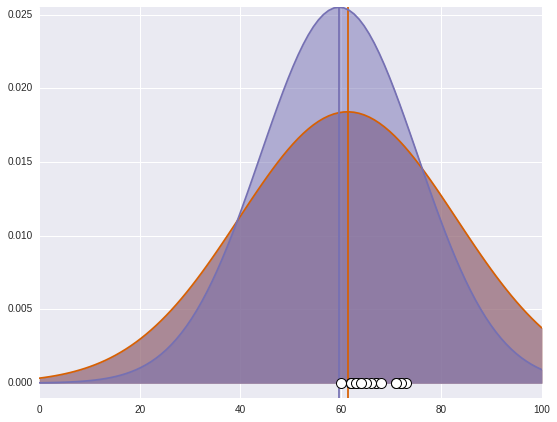

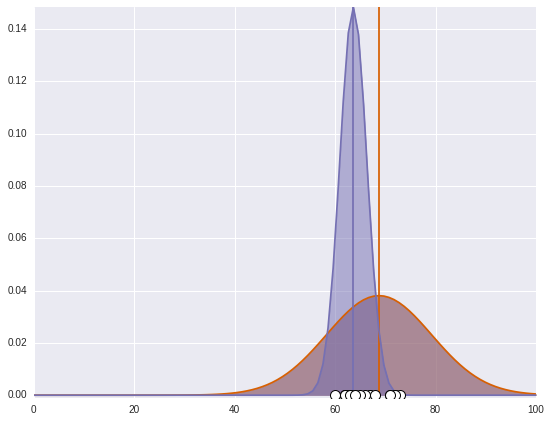

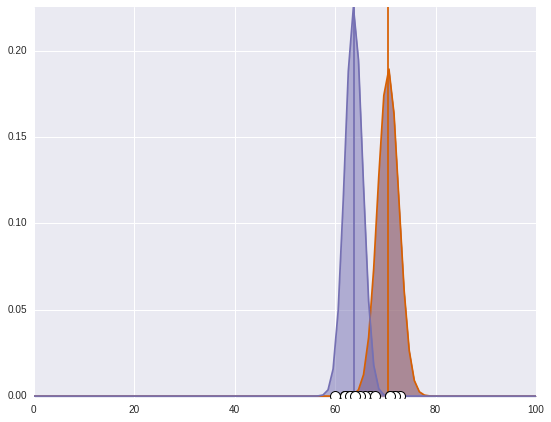

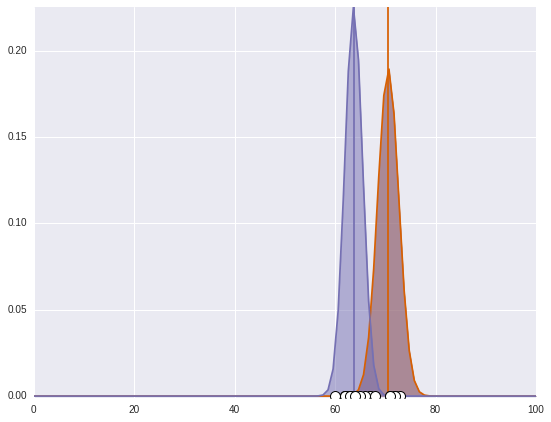

In [21]:
height = data['Height (in)']
n = len(height)

# Ground truthish
_mus = np.array([[0, data.groupby('Gender').mean().iat[0, 0]], 
                 [data.groupby('Gender').mean().iat[1, 0], 0]])
_sigmas = np.array([[[5, 0], [0, 5]], 
                    [[5, 0],[0, 5]]])
_pis = np.array([0.5, 0.5]) # priors

# initial random guesses for parameters
np.random.seed(0)

pis = np.random.random(2)
pis /= pis.sum()
mus = np.random.random((2,2))
sigmas = np.array([np.eye(2)] * 2) * height.std()

# generate our noisy x values
xs = np.concatenate([np.random.multivariate_normal(mu, sigma, int(pi*n))
                    for pi, mu, sigma in zip(_pis, _mus, _sigmas)])

ll, pis, mus, sigmas = em_gmm_orig(xs, pis, mus, sigmas)

In [22]:
k = 4
n_draws = 500
sigma = .7
random_state = 0
dot_size = 50
cmap = 'viridis'

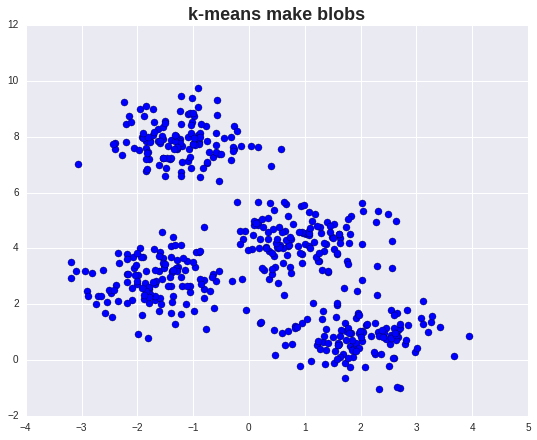

In [23]:
from sklearn.datasets.samples_generator import make_blobs

X, y_true = make_blobs(n_samples = n_draws,
                       centers = k,
                       cluster_std = sigma,
                       random_state = random_state)

fig, ax = plt.subplots(figsize=(9,7))
ax.scatter(X[:, 0], X[:, 1], s=dot_size)
plt.title('k-means make blobs', fontsize=18, fontweight='demi')

In [24]:
# sample implementation
# code sourced from: 
#   http://nbviewer.jupyter.org/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.11-K-Means.ipynb

from sklearn.metrics import pairwise_distances_argmin

def find_clusters(X, n_clusters, rseed=2):
    # 1. Random initialization (choose random clusters)
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]

    while True:
        # 2a. Assign labels based on closest center
        labels = pairwise_distances_argmin(X, centers)

        # 2b. Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0) 
                                for i in range(n_clusters)])

        # 2c. Check for convergence
        if np.all(centers == new_centers):
            break
        centers = new_centers
    
    return centers, labels

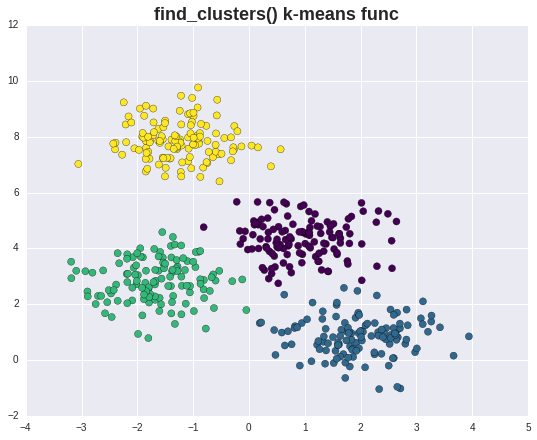

In [25]:
# let's test the implementation

centers, labels = find_clusters(X, k)

fig, ax = plt.subplots(figsize=(9,7))
ax.scatter(X[:, 0], X[:, 1], c=labels, s=dot_size, cmap=cmap)
plt.title('find_clusters() k-means func', fontsize=18, fontweight='demi')

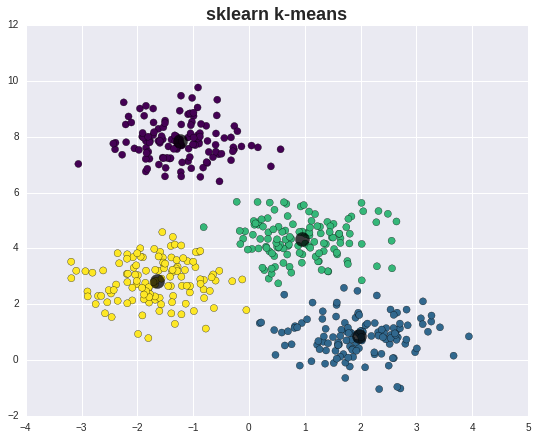

In [26]:
# now let's compare this to the sklearn's KMeans() algorithm

# fit k-means to blobs

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=k)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

# visualize prediction
fig, ax = plt.subplots(figsize=(9,7))
ax.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=dot_size, cmap=cmap)

# get centers for plot
centers = kmeans.cluster_centers_
ax.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.75)
plt.title('sklearn k-means', fontsize=18, fontweight='demi')

In [27]:
# code sourced from:
#   http://nbviewer.jupyter.org/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/06.00-Figure-Code.ipynb#Covariance-Type

from ipywidgets import interact

def plot_kmeans_interactive(min_clusters=1, max_clusters=6):
    X, y = make_blobs(n_samples=300, centers=4,
                      random_state=0, cluster_std=0.60)
        
    def plot_points(X, labels, n_clusters):
        plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis',
                    vmin=0, vmax=n_clusters - 1);
            
    def plot_centers(centers):
        plt.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c=np.arange(centers.shape[0]),
                    s=200, cmap='viridis')
        plt.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c='black', s=50)
            

    def _kmeans_step(frame=0, n_clusters=4):
        rng = np.random.RandomState(2)
        labels = np.zeros(X.shape[0])
        centers = rng.randn(n_clusters, 2)

        nsteps = frame // 3

        for i in range(nsteps + 1):
            old_centers = centers
            if i < nsteps or frame % 3 > 0:
                labels = pairwise_distances_argmin(X, centers)

            if i < nsteps or frame % 3 > 1:
                centers = np.array([X[labels == j].mean(0)
                                    for j in range(n_clusters)])
                nans = np.isnan(centers)
                centers[nans] = old_centers[nans]

        # plot the data and cluster centers
        plot_points(X, labels, n_clusters)
        plot_centers(old_centers)

        # plot new centers if third frame
        if frame % 3 == 2:
            for i in range(n_clusters):
                plt.annotate('', centers[i], old_centers[i], 
                             arrowprops=dict(arrowstyle='->', linewidth=1))
            plot_centers(centers)

        plt.xlim(-4, 4)
        plt.ylim(-2, 10)

        if frame % 3 == 1:
            plt.text(3.8, 9.5, "1. Reassign points to nearest centroid",
                     ha='right', va='top', size=14)
        elif frame % 3 == 2:
            plt.text(3.8, 9.5, "2. Update centroids to cluster means",
                     ha='right', va='top', size=14)
    
    return interact(_kmeans_step, frame=[0, 50],
                    n_clusters=[min_clusters, max_clusters])

plot_kmeans_interactive();

ImportError: No module named 'ipywidgets'